## Etape 3.2 : Analyse des correlations

In [18]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Chemins
DATA_DIR = "../data"
OUTPUT_DIR = "../data/output"
PARQUET_DIR = "../data/output/consommations_clean"

In [19]:
# récupération des données précédentes
df_final = pd.read_csv("../data/output/consommations_enrichies.csv" , sep=",")

### Calculer la matrice de correlation entre :

- Consommations (electricite, gaz, eau)

In [ ]:
# Sélection des colonnes d'intérêt
colonnes_corr = [
    'consommation_clean',      # consommation totale (on filtrera par type d'énergie plus tard)
    'temperature_c',
    'humidite_pct',
    'rayonnement_solaire_wm2',
    'vitesse_vent_kmh',
    'precipitation_mm',
    'surface_m2',
    'nb_occupants_moyen',
    'annee_construction'
]

df_corr = df_final[colonnes_corr].copy()


In [21]:
df_energy = df_final.pivot_table(
    index='timestamp',
    columns='type_energie',
    values='consommation_clean',
    aggfunc='sum'
).reset_index()

# Fusionner avec les variables météo et bâtiment
df_corr = df_energy.merge(
    df_final[['timestamp','temperature_c','humidite_pct','rayonnement_solaire_wm2','vitesse_vent_kmh','precipitation_mm']].drop_duplicates(),
    on='timestamp'
)
# Ajouter les caractéristiques du bâtiment (si identiques pour tous les timestamps)
df_corr['surface_m2'] = df_final['surface_m2'].iloc[0]
df_corr['nb_occupants_moyen'] = df_final['nb_occupants_moyen'].iloc[0]
df_corr['annee_construction'] = df_final['annee_construction'].iloc[0]


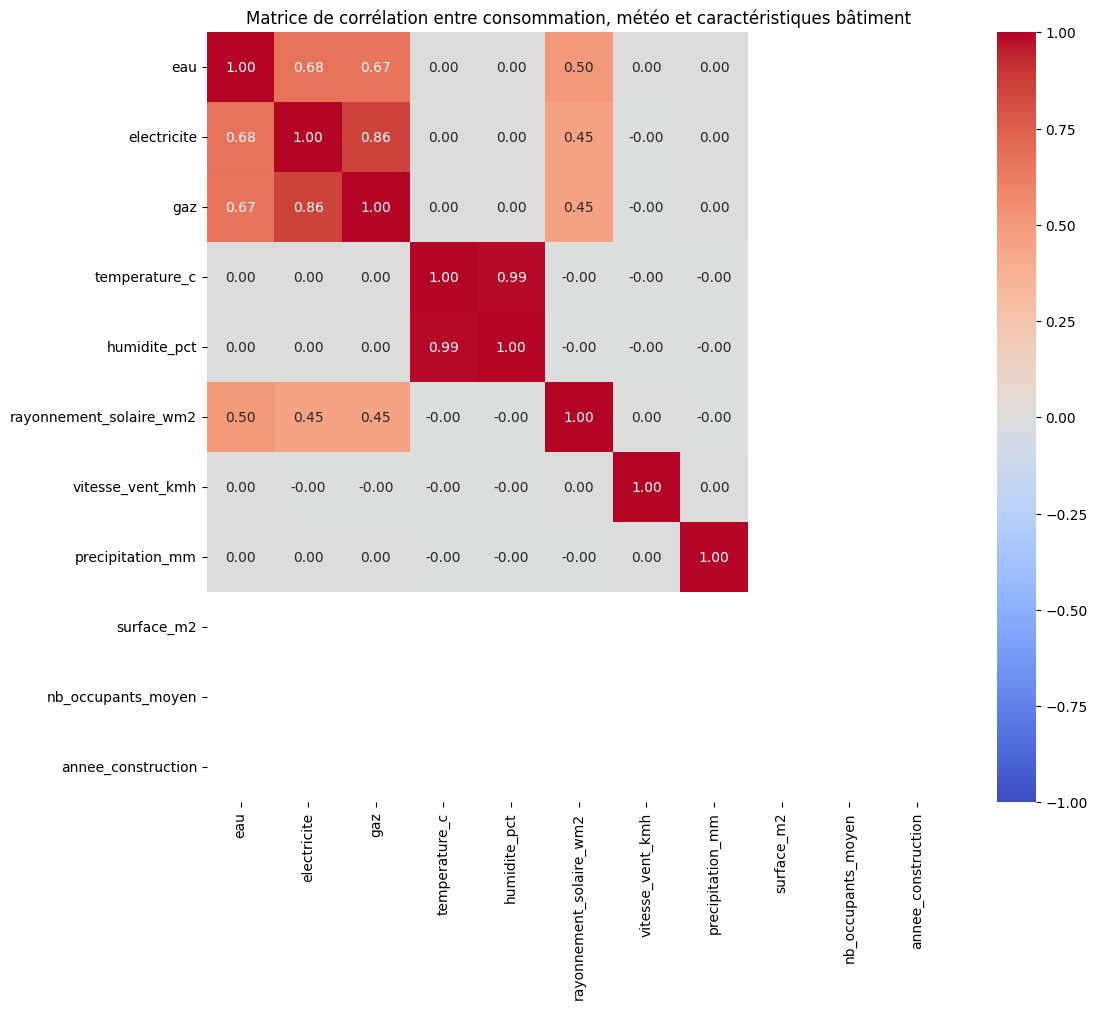

In [29]:
output_dir = "../data/output/graphics"
os.makedirs(output_dir, exist_ok=True)

df_corr_numeric = df_corr.select_dtypes(include='number')

corr_matrix = df_corr_numeric.corr()


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice de corrélation entre consommation, météo et caractéristiques bâtiment")
plt.savefig("../data/output/graphics/07_matrice_correlation.png", dpi=300, bbox_inches='tight')


- Identifier les correlations significatives (>0.5 ou <-0.5)

In [23]:
# Déplier la matrice
corr_long = corr_matrix.unstack().reset_index()
corr_long.columns = ['Variable1','Variable2','Correlation']

# Supprimer les auto-corrélations
corr_long = corr_long[corr_long['Variable1'] != corr_long['Variable2']]

# Filtrer corrélations >0.5 ou <-0.5
corr_significatives = corr_long[(corr_long['Correlation'] > 0.5) | (corr_long['Correlation'] < -0.5)]
corr_significatives.sort_values(by='Correlation', ascending=False)


,Variable1,Variable2,Correlation
37,temperature_c,humidite_pct,0.991499
47,humidite_pct,temperature_c,0.991499
13,electricite,gaz,0.856740
23,gaz,electricite,0.856740
1,eau,electricite,0.675731
11,electricite,eau,0.675731
2,eau,gaz,0.671491
22,gaz,eau,0.671491


- Analyser l'impact de la temperature sur la consommation de chauffage

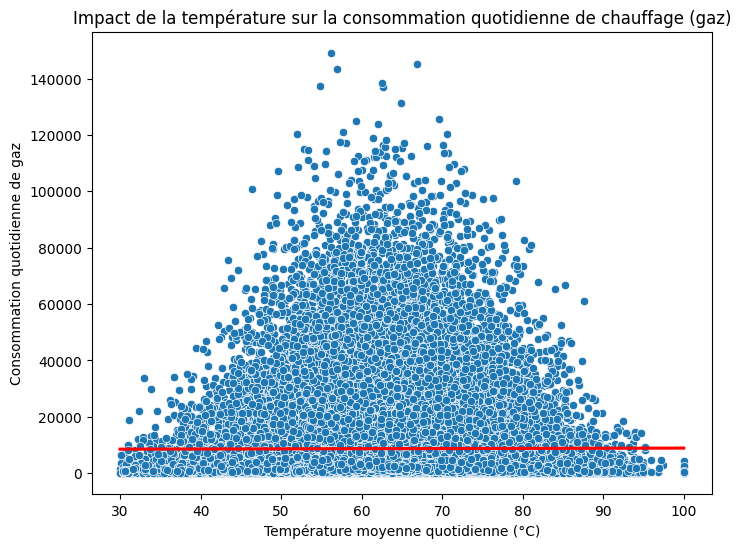

In [ ]:
# Filtrer les données pour le chauffage (gaz)
df_chauffage = df_final[df_final['type_energie'] == 'gaz']

# Tracer scatter + regression
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_chauffage, x='temperature_c', y='consommation_clean')
sns.regplot(data=df_chauffage, x='temperature_c', y='consommation_clean', scatter=False, color='red')
plt.title("Impact de la température sur la consommation de chauffage (gaz)")
plt.xlabel("Température (°C)")
plt.ylabel("Consommation gaz")

# Sauvegarder le graphique
plt.savefig("../data/output/graphics/07_impact_temperature_gaz.png", dpi=300, bbox_inches='tight')

- Etudier l'effet du rayonnement solaire sur la consommation electrique

Text(0, 0.5, 'Consommation électrique')

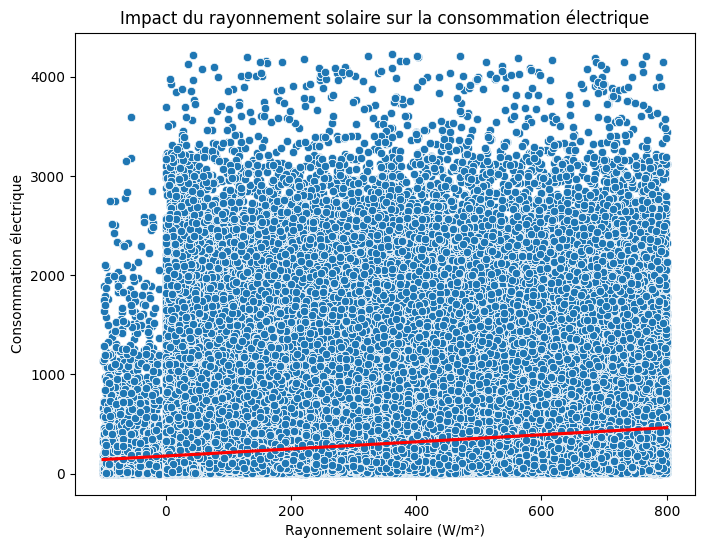

In [ ]:
# Filtrer les données pour l'électricité
df_elec = df_final[df_final['type_energie'] == 'electricite']

# Tracer scatter + regression
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_elec, x='rayonnement_solaire_wm2', y='consommation_clean')
sns.regplot(data=df_elec, x='rayonnement_solaire_wm2', y='consommation_clean', scatter=False, color='red')
plt.title("Impact du rayonnement solaire sur la consommation électrique")
plt.xlabel("Rayonnement solaire (W/m²)")
plt.ylabel("Consommation électrique")

# Sauvegarder le graphique
plt.savefig("../data/output/graphics/07_impact_solaire_electrique.png", dpi=300, bbox_inches='tight')
